# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from tensorflow import keras
import os
import time
import random
import glob # Khoa's stuff

# Utilities
import scipy.io.wavfile as wav
from utils.audio_spectrogram import stft
from PIL import Image

# Models
from models.deepfake_generator import generator
from models.visual_quality_discriminator import quality_discriminator

2023-01-30 05:10:56.076902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 05:10:56.619356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11/lib64:
2023-01-30 05:10:56.619427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/khoa/.local/lib/python3.10/site-pac

# Test models

(1, 256, 256, 6)
(1, 6, 513, 1)
Model: "image"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 6)       1770      
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 123, 32)      4832      
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 60, 64)       51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 28, 128)       204928    
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 13, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 6, 512)        1180160   
                                                                 
 conv2d_6 (Conv2D)           

2023-01-30 05:10:57.356708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:10:57.375827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:10:57.376031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 05:10:57.376437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 audio_input (InputLayer)       [(None, 6, 513, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 6)  1770        ['image_input[0][0]']            
                                                                                                  
 resizing (Resizing)            (None, 32, 32, 1)    0           ['audio_input[0][0]'

2023-01-30 05:10:58.851796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


(2, 256, 256, 3)


2023-01-30 05:10:59.456133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


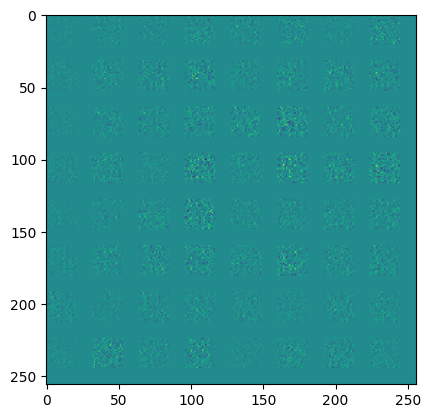

In [2]:
img = Image.open("./test_face.png")
img_arr = np.asarray(img)

# create a mask
img_masked = img_arr.copy()
img_masked[256//2:,...] = 0

# plt.imshow(img_masked)
# display the mask, and the output image
# cv2.imshow('Masked Image', img_masked)

# concatenate masked ground truth to pose prior
img_concat = np.concatenate([img_arr, img_masked], axis=2)

# normalize
img_concat = np.expand_dims(img_concat//255, axis=0)

img_arr = np.reshape(img_arr, newshape=(1, 256, 256, 3))

audio_samplerate, audio = wav.read("./test_audio.wav")
audio_arr = stft(audio, 2 ** 10) # what is this?
audio_arr = np.reshape(audio_arr, newshape=(1, 6, 513, 1))

print(img_concat.shape)
print(audio_arr.shape)

# Define models
gen = generator()
qual_disc = quality_discriminator()


generated_img = gen([img_concat, audio_arr], training=False)

print(generated_img.shape)

plt.imshow(generated_img[0, :, :, 0])

# Constants

In [3]:
EPOCHS = 5
BATCH_SIZE = 200
POSE_PRIOR = Image.open("./test_face.png") # constant for now
POSE_PRIOR = np.asarray(POSE_PRIOR)

# Get randomized dataset batch
We can't possibly hold everything at once

In [4]:
def khoas_get_batch(batch_size):
    """
    Khoa's custom function
    The real stuff needs the real function
    """
    data_path = './test_data/'

    png_list = []
    for file in os.listdir(data_path):
        if file.endswith('png'):
            png_list.append(file)

    image_samples = []
    gen_input_samples = [] # Specifically to work with Huy's data, should change
    audio_samples = []

    for img_name in random.sample(png_list, batch_size):
        img_name = data_path+img_name
        name = img_name[:-4] # name of file without extension
        audio_name = name + '.wav'# name of audio file
        img = Image.open(img_name)
        img_arr = np.asarray(img)
        image_samples.append(img_arr//255)

        video_name = ''.join([i for i in name if not i.isdigit()])
        pose_prior_name = img_name

        # randomly choose a pose prior of the same person
        while pose_prior_name == img_name:
            pose_prior_name = random.choice(glob.glob(video_name+'*.png'))
            print(pose_prior_name)

        pose_prior = Image.open(pose_prior_name)
        pose_prior = np.asarray(pose_prior)

        img_masked = img_arr.copy()
        # create a mask
        img_masked[256//2:,...] = 0

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([POSE_PRIOR, img_masked], axis=2)
        # expected shape (256, 256, 6)
        # normalize
        gen_input_samples.append(img_concat//255)

        audio_samplerate, audio = wav.read(audio_name)
        audio_arr = stft(audio, 2 ** 10) # what is this?
        audio_samples.append(audio_arr)

    image_samples = np.asarray(image_samples)
    gen_input_samples = np.asarray(gen_input_samples)
    audio_samples = np.asarray(audio_samples)
        
    # It should go without saying that the order needs to match
    return image_samples, gen_input_samples, audio_samples

# Define Loss Functions and Optimizers

In [5]:
quality_discriminator_loss = keras.losses.BinaryCrossentropy(from_logits=True)
generator_loss = keras.losses.MeanAbsoluteError() # Also known as L1 reconstruction loss

generator_optimizer = tf.keras.optimizers.Adam(1e-3)
quality_discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

# Misc

# Process generator input data
Essentially a reference face (pose prior) concatenated channel-wise with the masked original face

In [6]:
def process_gen_imgs(images): 
    """
    Assumes image is normalized beforehands and is a numpy array with shape (256, 256, 3)
    TODO: Random pose prior
    """
    output = []
    for img in images:
        img_masked = img.copy()
        # create a mask
        img_masked[256//2:,...] = 0

        # concatenate masked ground truth to pose prior
        img_concat = np.concatenate([POSE_PRIOR, img_masked], axis=2)
        # expected shape (256, 256, 6)
        output.append(img_concat)

    return output

In [7]:
@tf.function
def train_step(images, gen_imgs, audio_samples):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen([gen_imgs, audio_samples], training=True)
        
        real_output = qual_disc(images, training=True)
        fake_output = qual_disc(generated_images, training=True)

        gen_loss = generator_loss(images, generated_images)
        disc_loss = quality_discriminator_loss(real_output, fake_output)

        gradients_of_generator =  gen_tape.gradient(gen_loss, gen_imgs.trainable_variables)
        gradients_of_quality_discriminator = disc_tape.gradient(disc_loss, qual_disc.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
        quality_discriminator_optimizer.apply_gradients(zip(gradients_of_quality_discriminator, qual_disc.trainable_variables))

# Train

In [8]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig("./generate_images/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [9]:
def train_in_batch(batch, epoch):
    start = time.time()

    train_step(batch[0], batch[1], batch[2])

    # Produces images for the GIF
    display.clear_output(wait=True)
    generate_and_save_images(gen, epoch + 1, POSE_PRIOR) # Maybe my face?
    # if (epoch+1) % 15 == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

    

In [10]:
for epoch in range(EPOCHS):
    batch = khoas_get_batch(BATCH_SIZE)
    train_in_batch(batch, epoch)

display.clear_output(wait=True)
generate_and_save_images(gen, 100, POSE_PRIOR)

./test_data/REAL_akrubjfzzc_123.png
./test_data/REAL_adohdulfwb_259.png
./test_data/REAL_adohdulfwb_23.png
./test_data/REAL_abmjszfycr_46.png
./test_data/REAL_abmjszfycr_24.png
./test_data/REAL_adohdulfwb_132.png
./test_data/REAL_adohdulfwb_6.png
./test_data/REAL_akrubjfzzc_111.png
./test_data/REAL_abmjszfycr_198.png
./test_data/REAL_adohdulfwb_148.png
./test_data/REAL_abmjszfycr_183.png
./test_data/REAL_adohdulfwb_174.png
./test_data/REAL_akrubjfzzc_129.png
./test_data/REAL_abmjszfycr_58.png
./test_data/REAL_abmjszfycr_1.png
./test_data/REAL_abmjszfycr_67.png
./test_data/REAL_abmjszfycr_228.png
./test_data/REAL_akrubjfzzc_224.png
./test_data/REAL_adohdulfwb_237.png
./test_data/REAL_akrubjfzzc_98.png
./test_data/REAL_abmjszfycr_279.png
./test_data/REAL_aayfryxljh_17.png
./test_data/REAL_abmjszfycr_214.png
./test_data/REAL_akrubjfzzc_138.png
./test_data/REAL_ajiyrjfyzp_223.png
./test_data/REAL_abmjszfycr_295.png
./test_data/REAL_ajiyrjfyzp_236.png
./test_data/REAL_adohdulfwb_92.png
./te

ValueError: in user code:

    File "/tmp/ipykernel_86392/1241664201.py", line 9, in train_step  *
        gen_loss = generator_loss(images, generated_images)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__  **
        losses = call_fn(y_true, y_pred)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/khoa/.local/lib/python3.10/site-packages/keras/losses.py", line 1641, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 400 and 200 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](combined_model/conv2d_transpose_2/Tanh, mean_absolute_error/Cast)' with input shapes: [400,256,256,3], [200,256,256,3].


# Demo